In [1]:
from structure import structure
from GPyOpt.methods import BayesianOptimization
import numpy as np
import matplotlib.pyplot as plt
from GPTutorial.code.gaussian_process import Multifidelity_GP
from PyNite import Visualization
from scipy import optimize
np.random.seed(1)

In [7]:
n = 1
high_fidelity = "beam"
low_fidelity = "equiv_cant"

In [8]:
def f_hf(X):
    return(structure(high_fidelity, n, X[0], 1*10**7).score)
def f_lf(X):
    return(structure(low_fidelity, n, X[0], 1*10**7).score)

In [9]:
node_domain = [{'name':'node_coord', 'type':'continuous', 'domain':(0, 1)}]
d_domain = [{'name':'member_d', 'type':'continuous', 'domain':(0, 0.1)}]
domain = node_domain*n*3 + d_domain*int((n+1)*8+n*(n-1)/2)

In [10]:
hf_opt = BayesianOptimization(f_hf,
                             domain=domain,
                             acquisition_type="EI",
                             model_type='GP',
                             exact_feval=True)
hf_opt.run_optimization(max_iter = 50, eps=1e-6, verbosity=True)
X_H, y_H = hf_opt.get_evaluations()
X_H, y_H = X_H[(y_H<1*10**9).T[0],:], y_H[(y_H<1*10**9).T[0],:]

num acquisition: 1, time elapsed: 0.47s
num acquisition: 2, time elapsed: 0.83s
num acquisition: 3, time elapsed: 1.17s
num acquisition: 4, time elapsed: 1.47s
num acquisition: 5, time elapsed: 1.95s
num acquisition: 6, time elapsed: 2.37s
num acquisition: 7, time elapsed: 2.67s
num acquisition: 8, time elapsed: 3.00s
num acquisition: 9, time elapsed: 3.30s
num acquisition: 10, time elapsed: 3.65s
num acquisition: 11, time elapsed: 3.96s
num acquisition: 12, time elapsed: 4.27s
num acquisition: 13, time elapsed: 4.64s
num acquisition: 14, time elapsed: 4.99s
num acquisition: 15, time elapsed: 5.31s
num acquisition: 16, time elapsed: 5.74s
num acquisition: 17, time elapsed: 6.16s
num acquisition: 18, time elapsed: 6.70s
num acquisition: 19, time elapsed: 7.33s
num acquisition: 20, time elapsed: 7.73s
num acquisition: 21, time elapsed: 8.19s
num acquisition: 22, time elapsed: 8.67s
num acquisition: 23, time elapsed: 9.09s
num acquisition: 24, time elapsed: 9.55s
num acquisition: 25, time

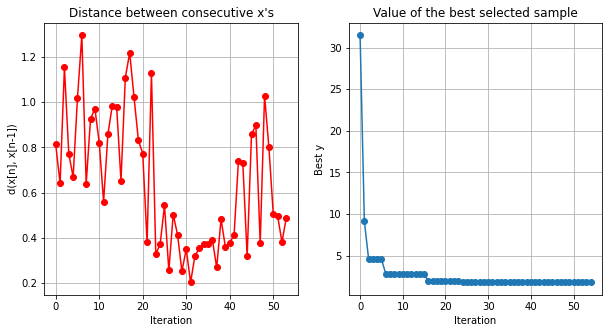

In [11]:
hf_opt.plot_convergence()

In [12]:
lf_opt = BayesianOptimization(f_lf,
                             domain=domain,
                             acquisition_type="EI",
                             model_type='GP',
                             exact_feval=True)
lf_opt.run_optimization(max_iter = 100, eps=1e-6, verbosity=True)
X_L, y_L = lf_opt.get_evaluations()
X_L, y_L = X_L[(y_L<1*10**9).T[0],:], y_L[(y_L<1*10**9).T[0],:] 

num acquisition: 1, time elapsed: 0.28s
num acquisition: 2, time elapsed: 0.64s
num acquisition: 3, time elapsed: 1.02s
num acquisition: 4, time elapsed: 1.53s
num acquisition: 5, time elapsed: 2.22s
num acquisition: 6, time elapsed: 2.63s
num acquisition: 7, time elapsed: 2.95s
num acquisition: 8, time elapsed: 3.28s
num acquisition: 9, time elapsed: 3.60s
num acquisition: 10, time elapsed: 3.91s
num acquisition: 11, time elapsed: 4.14s
num acquisition: 12, time elapsed: 4.46s
num acquisition: 13, time elapsed: 4.70s
num acquisition: 14, time elapsed: 4.96s
num acquisition: 15, time elapsed: 5.21s
num acquisition: 16, time elapsed: 5.43s
num acquisition: 17, time elapsed: 5.69s
num acquisition: 18, time elapsed: 5.90s
num acquisition: 19, time elapsed: 6.14s
num acquisition: 20, time elapsed: 6.43s
num acquisition: 21, time elapsed: 6.67s
num acquisition: 22, time elapsed: 6.87s
num acquisition: 23, time elapsed: 7.11s
num acquisition: 24, time elapsed: 7.40s
num acquisition: 25, time

In [13]:
mf_model = Multifidelity_GP(X_L, y_L, X_H, y_H)
while mf_model.jitter <= 0.1:
    try:
        mf_model.train()
    except np.linalg.LinAlgError as err:
        mf_model.jitter = mf_model.jitter*10
    else:
        print(mf_model.jitter)
        break

Total number of parameters: 43
1e-06


In [14]:
#random test point
node_locs = [0.5, 0.2, 0.3]
member_ds = [0.05]*16
X = [node_locs+member_ds]

In [36]:
print(mf_model.predict([X_H[0]]))
print(mf_model.predict([hf_opt.x_opt]))
print(mf_model.predict([np.add(hf_opt.x_opt, 0.00001)]))
print(f_hf([np.add(hf_opt.x_opt, 0.1)]))
print(mf_model.predict([X_L[0]]))
print(mf_model.predict([lf_opt.x_opt]))
print(mf_model.predict(X))

(array([[103.5428941]]), array([[262.51020261]]))
(array([[27.55283803]]), array([[811.37607489]]))
(array([[27.53069783]]), array([[811.13433188]]))
3.2541314899404377
(array([[126.84163146]]), array([[1.59465121]]))
(array([[18.9798073]]), array([[1.59465049]]))
(array([[177.7511429]]), array([[1073.20638549]]))


In [54]:
mf_model.predict([X_H[9]])[1][0][0]

1715.44885809283

In [54]:
def f_mf(X):
    X = np.atleast_2d(X)
    y_pred, y_var = mf_model.predict(X)
    if y_pred[0][0] > 0:
        return(y_pred[0][0])
    else:
        return(10**9)

In [50]:
f_mf([np.array(hf_opt.x_opt)])

838.9289129133249

In [58]:
res = optimize.minimize(f_mf, hf_opt.x_opt, bounds = [i['domain'] for i in domain])

In [59]:
res.x

array([0.6982051 , 0.87069685, 0.43452822, 0.1       , 0.0585905 ,
       0.09821382, 0.02882689, 0.08484231, 0.07335288, 0.09316408,
       0.1       , 0.0889933 , 0.05651616, 0.08100632, 0.1       ,
       0.08146849, 0.07496583, 0.0638441 , 0.02894214])

In [60]:
opt_struct = structure(high_fidelity, n, res.x, 1*10**7)
print(f'score = {opt_struct.score}')
print(f'mass = {opt_struct.mystruct.mass}')
print(f'EI = {opt_struct.mystruct.get_EI(100)}')

score = 1.4236239348660615
mass = 0.6401275749886157
EI = 5606964.065061034


In [34]:
mf_opt = BayesianOptimization(f_mf,
                             domain=domain,
                             acquisition_type="EI",
                             model_type='GP')
mf_opt.run_optimization(max_iter = 200, eps=1e-6, verbosity=True)

num acquisition: 1, time elapsed: 0.34s
num acquisition: 2, time elapsed: 0.63s
num acquisition: 3, time elapsed: 0.98s
num acquisition: 4, time elapsed: 1.35s
num acquisition: 5, time elapsed: 1.62s
num acquisition: 6, time elapsed: 1.92s
num acquisition: 7, time elapsed: 2.27s
num acquisition: 8, time elapsed: 2.64s
num acquisition: 9, time elapsed: 3.01s
num acquisition: 10, time elapsed: 3.36s
num acquisition: 11, time elapsed: 3.64s
num acquisition: 12, time elapsed: 3.92s
num acquisition: 13, time elapsed: 4.30s
num acquisition: 14, time elapsed: 4.77s
num acquisition: 15, time elapsed: 5.21s
num acquisition: 16, time elapsed: 5.84s
num acquisition: 17, time elapsed: 6.26s
num acquisition: 18, time elapsed: 6.81s
num acquisition: 19, time elapsed: 7.33s
num acquisition: 20, time elapsed: 7.89s
num acquisition: 21, time elapsed: 8.51s
num acquisition: 22, time elapsed: 9.10s
num acquisition: 23, time elapsed: 9.61s
num acquisition: 24, time elapsed: 10.31s
num acquisition: 25, tim

num acquisition: 195, time elapsed: 76.64s
num acquisition: 196, time elapsed: 77.27s
num acquisition: 197, time elapsed: 77.97s
num acquisition: 198, time elapsed: 78.67s
num acquisition: 199, time elapsed: 79.30s
num acquisition: 200, time elapsed: 80.05s


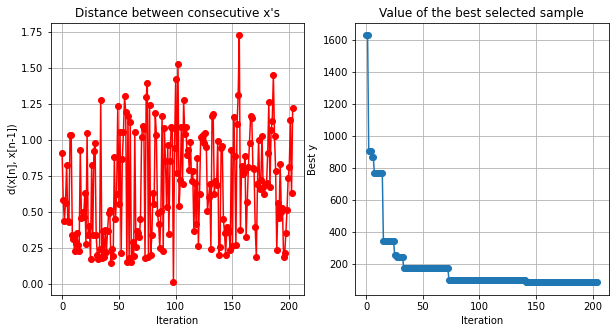

In [55]:
mf_opt.plot_convergence()

In [56]:
print(mf_opt.x_opt)
print(mf_opt.fx_opt)
print(mf_model.predict([mf_opt.x_opt]))
opt_struct = structure(high_fidelity, n, mf_opt.x_opt, 1*10**7)
print(f'score = {opt_struct.score}')
print(f'mass = {opt_struct.mystruct.mass}')
print(f'EI = {opt_struct.mystruct.get_EI(100)}')

[0.15848363 0.12353703 0.2540377  0.1        0.1        0.1
 0.1        0.1        0.1        0.1        0.1        0.1
 0.1        0.         0.05284157 0.1        0.         0.1
 0.1       ]
82.79766576441762
(array([[43.9300319]]), array([[38.86763386]]))
score = 1.8025674706671913
mass = 0.8425636034560471
EI = 5102030.749678483


In [61]:
print(hf_opt.x_opt)
print(f_hf([hf_opt.x_opt]))
hf_opt_struct = structure(high_fidelity, n, hf_opt.x_opt, 1*10**7)
print(f'score = {hf_opt_struct.score}')
print(f'mass = {hf_opt_struct.mystruct.mass}')
print(f'EI = {hf_opt_struct.mystruct.get_EI(100)}')

[0.93136449 0.82751721 0.57963507 0.1        0.04476216 0.09761734
 0.00505926 0.08429586 0.06445431 0.09088129 0.1        0.08790042
 0.04199512 0.07466355 0.1        0.07528005 0.1        0.05177016
 0.005213  ]
1.768834535077421
score = 1.768834535077421
mass = 0.6275927646798879
EI = 4670187.242864895


In [62]:
print(lf_opt.x_opt)
lf_opt_struct = structure(high_fidelity, n, lf_opt.x_opt)
print(f'score = {lf_opt_struct.score}')
print(f'mass = {lf_opt_struct.mystruct.mass}')
print(f'EI = {lf_opt_struct.mystruct.get_EI(100)}')

[0.75853938 0.         0.         0.1        0.         0.1
 0.1        0.         0.         0.1        0.1        0.1
 0.1        0.1        0.1        0.1        0.         0.1
 0.1       ]
score = 4.4112571391360635
mass = 0.8138925068314204
EI = 2175159.205283013


In [63]:
import time

start = time.time()
f_hf(X)
end = time.time()
print(end - start)

start = time.time()
f_lf(X)
end = time.time()
print(end - start)

start = time.time()
mf_model.predict(X)
end = time.time()
print(end - start)

0.18828392028808594
0.05600714683532715
0.002012968063354492


hf: 0.2102820873260498

unit: 0.09271812438964844

equiv_cant: 0.05715179443359375

mf: 0.0023221969604492188